# Self-classifying Neural Cellular Automata (for Quick! Draw data).

This notebook contains a version of the [code](https://github.com/google-research/self-organising-systems/blob/master/notebooks/mnist_ca.ipynb) related to the Distill article on [Self-classifying MNIST Digits](https://distill.pub/2020/selforg/mnist/) and adapted for the [Quick! Draw](https://quickdraw.withgoogle.com/data) dataset.

This notebook is the "main" code of the project.

## Imports

In [1]:
import io
import PIL.Image, PIL.ImageDraw, PIL.ImageFilter
import base64
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from math import sqrt
import json

import tensorflow as tf
from tensorflow.keras.layers import Conv2D

from IPython.display import Image, clear_output

In [2]:
clear_output()

## Image manipulation utilities

In [3]:
def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def drawing_to_image(drawing, size=52):
    """Converts a QuickDraw drawing (i.e. a list of strokes in from the .ndjson file) to a 52x52 grayscale image.
    """
    # create a blank white canvas
    canvas_size = 256
    image = PIL.Image.new("L", (canvas_size, canvas_size), color=255)
    draw = PIL.ImageDraw.Draw(image)
    
    # draw the strokes on the canvas
    for stroke in drawing:
        coords = list(zip(stroke[0], stroke[1]))
        for i in range(len(coords) - 1):
            draw.line([coords[i], coords[i+1]], fill=0, width=10)
    
    image = image.resize((size, size), resample=PIL.Image.LANCZOS)
    # we only care about bitmaps...
    image = image.convert("1")

    return image

def display_image_grid(images, n):
    """Display a nxn grid of images."""
    fig, axes = plt.subplots(n, n, figsize=(10, 10))
    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            ax.imshow(images[i*n + j], cmap='gray')
            ax.axis('off')
    plt.show()

def tile2d(a, w=None):
  a = np.asarray(a)

  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))

  th, tw = a.shape[1:3]
  pad = (w - len(a)) % w
  a = np.pad(a, [(0, pad)] + [(0, 0)] * (a.ndim - 1), 'constant')
  h = len(a) // w

  a = a.reshape([h, w] + list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th * h, tw * w])
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

## Model 

### Utilities and hyperparameters

In [4]:
CHANNEL_N = 19 # number of CA state channels
BATCH_SIZE = 16
POOL_SIZE = BATCH_SIZE * 10
CELL_FIRE_RATE = 0.5

ADD_NOISE = True

### Model definition

In [5]:
class CAModel(tf.keras.Model):
  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE,
               add_noise=ADD_NOISE):
    # CHANNEL_N does not include the greyscale channel, but it does include the 10 possible outputs.
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate
    self.add_noise = add_noise

    # unlike in the growing CA case, we make the kernels learnable!
    self.perceive = tf.keras.Sequential([
          Conv2D(80, 3, activation=tf.nn.relu, padding="SAME"),
      ])

    self.dmodel = tf.keras.Sequential([
          Conv2D(80, 1, activation=tf.nn.relu),
          Conv2D(self.channel_n, 1, activation=None,
                       kernel_initializer=tf.zeros_initializer),
    ])

    self(tf.zeros([1, 3, 3, channel_n + 1]))  # dummy calls to build the model

  @tf.function
  def call(self, x, fire_rate=None, manual_noise=None):
    gray, state = tf.split(x, [1, self.channel_n], -1)
    ds = self.dmodel(self.perceive(x))
    if self.add_noise:
      if manual_noise is None:
        residual_noise = tf.random.normal(tf.shape(ds), 0., 0.02)
      else:
        residual_noise = manual_noise
      ds += residual_noise

    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
    living_mask = gray > 0.1
    residual_mask = update_mask & living_mask
    ds *= tf.cast(residual_mask, tf.float32)
    state += ds
    
    return tf.concat([gray, state], -1)

  # TODO the functions below will surely need modifications to work with quickdraw
  @tf.function
  def initialize(self, images):
    state = tf.zeros([tf.shape(images)[0], 28, 28, self.channel_n])
    images = tf.reshape(images, [-1, 28, 28, 1])
    return tf.concat([images, state], -1)

  @tf.function
  def classify(self, x):
    # The last 10 layers are the classification predictions, one channel
    # per class. Keep in mind there is no "background" class,
    # and that any loss doesn't propagate to "dead" pixels.
    return x[:,:,:,-10:]

In [6]:
CAModel().perceive.summary()

2023-08-15 17:24:42.386042: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-15 17:24:42.386061: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-15 17:24:42.386066: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-15 17:24:42.386096: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-15 17:24:42.386110: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (1, 3, 3, 80)             14480     
                                                                 
Total params: 14480 (56.56 KB)
Trainable params: 14480 (56.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-08-15 17:24:42.613464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [7]:
CAModel().dmodel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (1, 3, 3, 80)             6480      
                                                                 
 conv2d_5 (Conv2D)           (1, 3, 3, 19)             1539      
                                                                 
Total params: 8019 (31.32 KB)
Trainable params: 8019 (31.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-08-15 17:24:42.733117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


## Training

### Training preparation

In [8]:
class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

In [9]:
# TODO maybe add generate_tiled_figures?
def generate_pool_figures(pool, step_i):
  tiled_pool = tile2d(pool.x[:49, :, :, :1])
  ones = np.ones(72)
  tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :])
  tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :])
  tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None])
  tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None])
  imwrite('train_log/%04d_pool.jpg' % step_i, tiled_pool)

def visualize_batch(x0, x, step_i):
  vis0 = np.hstack(x0[..., :1])
  vis1 = np.hstack(x[..., :1])
  vis = np.vstack([vis0, vis1])
  vis = np.squeeze(vis, axis=-1) # for imwrite and imshow
  imwrite('train_log/batches_%04d.jpg' % step_i, vis)
  print('batch (before/after):')
  imshow(vis)

# TODO probably need to modify this function
def individual_l2_loss(model, x, y):
  t = y - model.classify(x)
  return tf.reduce_sum(t**2, [1, 2, 3]) / 2

def batch_l2_loss(model, x, y):
  return tf.reduce_mean(individual_l2_loss(model, x, y))

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.5)
  pl.show()

In [10]:
# TODO maybe add evaluation (later)?

### Data manipulation and examination

In [11]:
# example run of the script (TODO sometimes jupyter fails for no reason??)
# %run utils/quickdraw_downloader.py --dir quickdraw_data --clean cat

In [12]:
#! I assume the data has already been downloaded, if you haven't done it already, use the 'quickdraw_downloader' script
data_dir = "quickdraw_data/"

Let's take a look at some drawings!

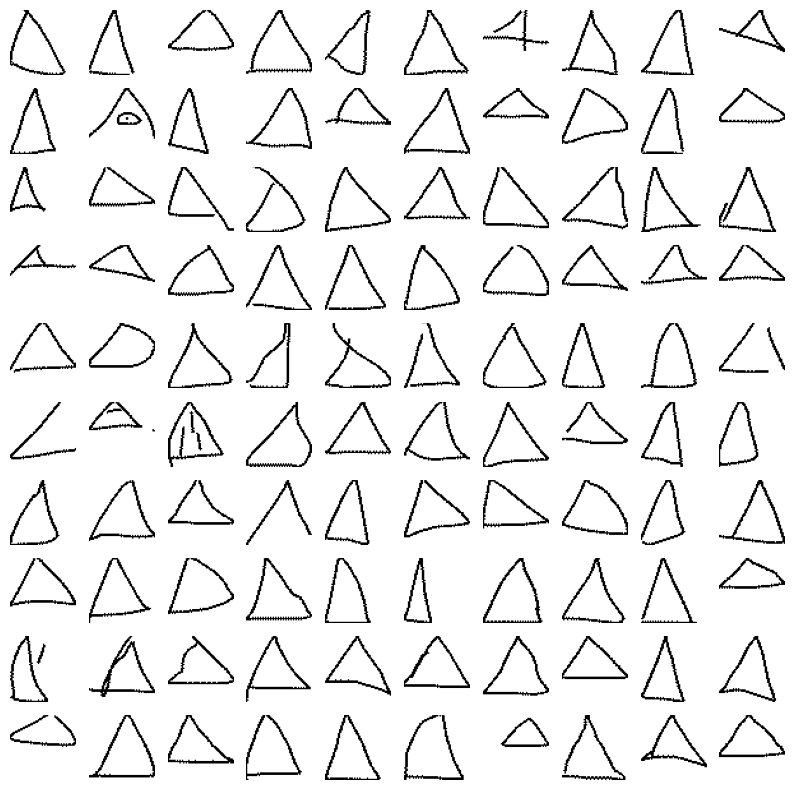

In [13]:
images = []
i = 0 # to avoid loading the whole dataset
with open(data_dir + "triangle.ndjson", "r") as file:
    for line in file:
        i += 1
        data = json.loads(line)
        image = drawing_to_image(data["drawing"])
        images.append(image)
        if i > 100:
            break
        # image.show()  

display_image_grid(images, int(sqrt(i)))

All good! Now we need to split the file, to more easily access training, validation and testing data.

In [14]:
# example splitting run (TODO orchestrate this with the data retrieval part for ease of use!)
# %run utils/split_data.py triangle.ndjson

In [ ]:
# TODO continue...

Let's finally wrap up the preparations, define our model and initialise training!

In [15]:
ca = CAModel()

loss_log = []

lr = 1e-3
# TODO change range limits!
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
      [30_000, 70_000], [lr, lr*0.1, lr*0.01])
trainer = tf.keras.optimizers.legacy.Adam(lr_sched)

starting_indexes = np.random.randint(0, x_train.shape[0] - 1, size=POOL_SIZE)
pool = SamplePool(x=ca.initialize(x_train[starting_indexes]).numpy(), 
                  y=y_train_pic[starting_indexes])

2023-08-15 17:24:43.666630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


NameError: name 'x_train' is not defined

In [ ]:
!mkdir -p train_log && rm -f train_log/*

### Training loop

batch (before/after):


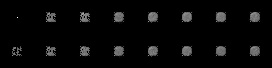

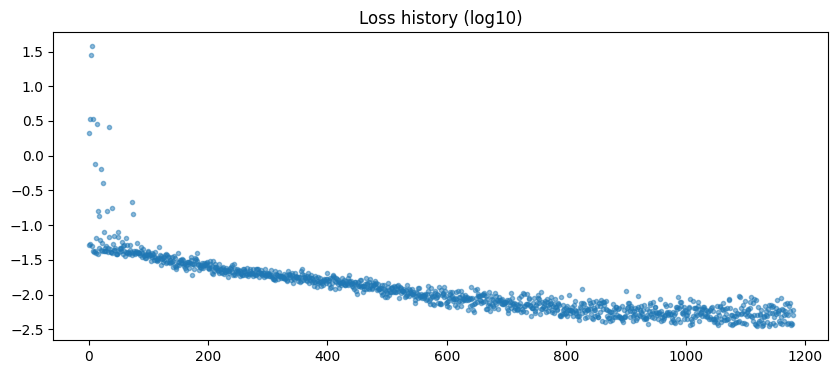

 step: 1190, log10(loss): -2.374

KeyboardInterrupt: 

In [ ]:
# TODO this code will surely need some heavy modifications!
@tf.function
def train_step(x, y):
  iter_n = 20
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    loss = batch_l2_loss(ca, x, y)
  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss

for i in range(1, 100000+1):
  if USE_PATTERN_POOL:
    batch = pool.sample(BATCH_SIZE)
    x0 = np.copy(batch.x)
    y0 = batch.y
    # we want half of them new. We remove 1/4 from the top and 1/4 from the
    # bottom.
    q_bs = BATCH_SIZE // 4

    new_idx = np.random.randint(0, x_train.shape[0]-1, size=q_bs)
    x0[:q_bs] = ca.initialize(x_train[new_idx])
    y0[:q_bs] = y_train_pic[new_idx]

    new_idx = np.random.randint(0, x_train.shape[0]-1, size=q_bs)
    new_x, new_y = x_train[new_idx], y_train_pic[new_idx]
    if MUTATE_POOL:
      new_x = tf.reshape(new_x, [q_bs, 28, 28, 1])
      mutate_mask = tf.cast(new_x > 0.1, tf.float32)
      mutated_x = tf.concat([new_x, x0[-q_bs:,:,:,1:] * mutate_mask], -1)

      x0[-q_bs:] = mutated_x
      y0[-q_bs:] = new_y

    else:
      x0[-q_bs:] = ca.initialize(new_x)
      y0[-q_bs:] = new_y

  else:
    b_idx = np.random.randint(0, x_train.shape[0]-1, size=BATCH_SIZE)
    x0 = ca.initialize(x_train[b_idx])
    y0 = y_train_pic[b_idx]

  x, loss = train_step(x0, y0)

  if USE_PATTERN_POOL:
    batch.x[:] = x
    batch.y[:] = y0 # This gets reordered, so you need to change it.
    batch.commit()

  step_i = len(loss_log)
  loss_log.append(loss.numpy())

  if step_i%100 == 0:
    generate_pool_figures(ca, pool, step_i)
  if step_i%200 == 0:
    clear_output()
    visualize_batch(ca, x0, x, step_i)
    plot_loss(loss_log)

  print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')

In [ ]:
# TODO evaluation, possibly?